## Football CNN

This notebook will emulate the CNN created in `2017-10-14-CNN-from-scratch.ipynb` and apply the architecture of the CNN to the football images data set in order to classify an image as "football game" or "other"

In [1]:
import os
import tensorflow as tf
import scipy.ndimage
from scipy.misc import imsave
import matplotlib.pyplot as plt
import numpy as np

import imFunctions as imf

%matplotlib inline

## Organize Images Into Training/Test sets

Arrange images to create a test and training data sets

NOTE: due to some other processing I do (playing around with ffmpeg, capturing from the camera etc), I have a ton of images ready for learning already in `~/football_imgs/{game,ad}`. In order to emulate the tutorial more closely, I'm going to arrange the folder structure similarly to the tutorial but symlink the images in a directory structure I have created for this notebook's purpose.

The directory structure for this notebook's purpose is:

{game,ad}/{train,test}

In [2]:
game_img_src_dir = '/home/brycemcd/football_imgs/game/small/'
ad_img_src_dir = '/home/brycemcd/football_imgs/ad/images/small/'

training_game_img_src_dir = 'data/football/game/train/'
testing_game_img_src_dir = 'data/football/game/test/'
training_ad_img_src_dir = 'data/football/ad/train/'
testing_ad_img_src_dir = 'data/football/ad/test/'

num_classes = 2

In [ ]:
game_imgs = os.listdir('/home/brycemcd/football_imgs/game/small/')
game_imgs[0:5]

In [ ]:
ad_imgs = os.listdir('/home/brycemcd/football_imgs/ad/images/small/')
ad_imgs[0:5]

In [ ]:
print("game imgs count: %s" % len(game_imgs))
print("ad imgs count: %s" % len(ad_imgs))

In [ ]:
game_train_cnt = round(len(game_imgs) * 0.85)
game_test_cnt  = len(game_imgs) - game_train_cnt

In [ ]:
import random

def create_training_data(img_src_dir, img_dst_dir, training_percentage):
    """Get a random set of images for training and symlink them to this notebook's directory structure"""
    all_imgs = os.listdir(img_src_dir)
    training_img_cnt = len(all_imgs) * training_percentage
    
    train_imgs = []

    while(len(os.listdir(img_dst_dir)) < training_img_cnt):
        img = random.choice(all_imgs)

        try:
            os.symlink( img_src_dir + img,
                        img_dst_dir + img)
            train_imgs.append(img)
            all_imgs.remove(img)
        except FileExistsError:
            continue
    return train_imgs

In [ ]:
def create_testing_data(img_src_dir, img_dst_dir, training_dir):
    "take all images that are not appropriated for training and make them test images"
    all_imgs = os.listdir(img_src_dir)
    training_imgs = os.listdir(training_dir)
    testing_imgs = set(all_imgs) - set(training_imgs)

    for img in testing_imgs:
        os.symlink( img_src_dir + img,
                    img_dst_dir + img)


In [ ]:
create_training_data(game_img_src_dir, training_game_img_src_dir, 0.85)
create_testing_data(game_img_src_dir, testing_game_img_src_dir, training_game_img_src_dir)

In [ ]:
len(os.listdir(training_game_img_src_dir))

In [ ]:
len(os.listdir(testing_game_img_src_dir))

In [ ]:
# This should be 0
training_img_set = set(os.listdir(training_game_img_src_dir))
testing_img_set = set(os.listdir(testing_game_img_src_dir))
len(training_img_set.intersection(testing_img_set))

In [ ]:
create_training_data(ad_img_src_dir, training_ad_img_src_dir, 0.85)
create_testing_data(ad_img_src_dir, testing_ad_img_src_dir, training_ad_img_src_dir)

In [ ]:
len(os.listdir(training_ad_img_src_dir))

In [ ]:
len(os.listdir(testing_ad_img_src_dir))

In [ ]:
# This should be 0
training_img_set = set(os.listdir(training_ad_img_src_dir))
testing_img_set = set(os.listdir(testing_ad_img_src_dir))
len(training_img_set.intersection(testing_img_set))

In [3]:
 # NOTE: in graphics the image is 320x240 (wxh), in linear alg. the shape is 240x320 (nxm)
num_samples = 4000
data_shape = [1, 240, 320, 1]

train_x = np.zeros(data_shape)
train_y = np.zeros([1, num_classes])

test_x = np.zeros(data_shape)
test_y = np.zeros([1, num_classes])

training_game_img_set = set(os.listdir(training_game_img_src_dir))
training_ad_img_set = set(os.listdir(training_ad_img_src_dir))

testing_game_img_set = set(os.listdir(testing_game_img_src_dir))
testing_ad_img_set = set(os.listdir(testing_ad_img_src_dir))

# TODO: make this a function ... sheesh
print("adding games to training set")
for img in list(training_game_img_set)[0:num_samples]:
    full_img = training_game_img_src_dir + img
    im = scipy.misc.imread(full_img, flatten=True, mode="I").astype(np.float32)
    im = im.reshape(data_shape)
    #print(im)
    train_x = np.vstack((train_x, im))
    train_y = np.vstack((train_y, [1, 0]))

print("adding not games to training set")
for img in list(training_ad_img_set)[0:num_samples]:
    full_img = training_ad_img_src_dir + img
    im = scipy.misc.imread(full_img, flatten=True, mode="I").astype(np.float32)
    im = im.reshape(data_shape)
    #print(im)
    train_x = np.vstack((train_x, im))
    train_y = np.vstack((train_y, [0, 1]))

print("adding games to test set")
for img in list(testing_game_img_set)[0: round(num_samples * 0.25)]:
    full_img = testing_game_img_src_dir + img
    im = scipy.misc.imread(full_img, flatten=True, mode="I").astype(np.float32)
    im = im.reshape(data_shape)
    #print(im)
    test_x = np.vstack((test_x, im))
    test_y = np.vstack((test_y, [1, 0]))

print("addming not games to test set")
for img in list(testing_ad_img_set)[0: round(num_samples * 0.25)]:
    full_img = testing_ad_img_src_dir + img
    im = scipy.misc.imread(full_img, flatten=True, mode="I").astype(np.float32)
    im = im.reshape(data_shape)
    #print(im)
    test_x = np.vstack((test_x, im))
    test_y = np.vstack((test_y, [0, 1]))
    
train_x -= np.mean([train_x], axis=1)
test_x -= np.mean([train_x], axis=1)

train_x = train_x[1:]
train_y = train_y[1:]

test_x = test_x[1:]
test_y = test_y[1:]

adding games to training set
adding not games to training set
adding games to test set
addming not games to test set


In [20]:
print("# of training samples: %s" % len(train_x))
print("# of training labels: %s" % len(train_y))

print("# of testing samples: %s" % len(test_x))
print("# of testing labels: %s" % len(test_y))

np.save('data/football/train_x', train_x)
np.save('data/football/train_y', train_y)

np.save('data/football/test_x', test_x)
np.save('data/football/test_y', test_y)

# of training samples: 8000
# of training labels: 8000
# of testing samples: 2000
# of testing labels: 2000


## Network Architecture

In [5]:
X = tf.placeholder(tf.float32, shape=(None, 240, 320, 1))
Y_ = tf.placeholder(tf.float32, [None, num_classes])

keepRate1 = tf.placeholder(tf.float32)
keepRate2 = tf.placeholder(tf.float32)

In [129]:
# CONVOLUTION 1 - 1
with tf.variable_scope('conv1_1') as scope:
    num_filters1_1 = 32
    filter1_1 = tf.Variable(tf.truncated_normal([3, 3, 1, num_filters1_1], 
                                                dtype=tf.float32,
                                                stddev=1e-1), 
                            name='weights1_1')
    stride = [1,1,1,1]
    conv = tf.nn.conv2d(X, filter1_1, stride, padding='SAME')
    
    biases = tf.Variable(tf.constant(0.0, 
                                     shape=[num_filters1_1], 
                                     dtype=tf.float32),
                        trainable=True,
                        name='biases1_1')
    
    out = tf.nn.bias_add(conv, biases)
    conv1_1 = tf.nn.sigmoid(out, name=scope.name)

In [7]:
# CONVOLUTION 1 - 2
with tf.name_scope('conv1_2'):
    num_filters1_2 = 32
    filter1_2 = tf.Variable(tf.truncated_normal([3, 3, num_filters1_1, num_filters1_2], 
                                                dtype=tf.float32,
                                                stddev=1e-1), 
                            name='weights1_2')
    
    stride = [1,1,1,1]
    conv = tf.nn.conv2d(conv1_1, filter1_2, stride, padding='SAME')
    
    biases = tf.Variable(tf.constant(0.0, shape=[num_filters1_2], dtype=tf.float32),
                         trainable=True, name='biases1_2')
    
    out = tf.nn.bias_add(conv, biases)
    conv1_2 = tf.nn.relu(out)

In [8]:
# POOL 1
with tf.name_scope('pool1'):
    pool1_1 = tf.nn.max_pool(conv1_2,
                             ksize=[1, 5, 5, 1],
                             strides=[1, 5, 5, 1],
                             padding='SAME',
                             name='pool1_1')
    pool1_1_drop = tf.nn.dropout(pool1_1, keepRate1)

In [9]:
# CONVOLUTION 2 - 1
with tf.name_scope('conv2_1'):
    filter2_1 = tf.Variable(tf.truncated_normal([3, 3, 32, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_1')
    conv = tf.nn.conv2d(pool1_1_drop, filter2_1, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_1')
    out = tf.nn.bias_add(conv, biases)
    conv2_1 = tf.nn.sigmoid(out)
    
# CONVOLUTION 2 - 2
with tf.name_scope('conv2_2'):
    filter2_2 = tf.Variable(tf.truncated_normal([3, 3, 64, 64], dtype=tf.float32,
                                                stddev=1e-1), name='weights2_2')
    conv = tf.nn.conv2d(conv2_1, filter2_2, [1, 1, 1, 1], padding='SAME')
    biases = tf.Variable(tf.constant(0.0, shape=[64], dtype=tf.float32),
                         trainable=True, name='biases2_2')
    out = tf.nn.bias_add(conv, biases)
    conv2_2 = tf.nn.relu(out)
    
# POOL 2
with tf.name_scope('pool2'):
    pool2_1 = tf.nn.max_pool(conv2_2,
                             ksize=[1, 5, 5, 1],
                             strides=[1, 5, 5, 1],
                             padding='SAME',
                             name='pool2_1')
    pool2_1_drop = tf.nn.dropout(pool2_1, keepRate1)

In [10]:
#FULLY CONNECTED 1
with tf.name_scope('fc1') as scope:
    shape = int(np.prod(pool2_1_drop.get_shape()[1:]))
    
    fc1w = tf.Variable(tf.truncated_normal([shape, 512], 
                                           dtype=tf.float32,
                                           stddev=1e-1), 
                       name='weights3_1')
    
    fc1b = tf.Variable(tf.constant(1.0, shape=[512], dtype=tf.float32),
                       trainable=True, 
                       name='biases3_1')
    
    pool2_flat = tf.reshape(pool2_1_drop, [-1, shape])
    
    out = tf.nn.bias_add(tf.matmul(pool2_flat, fc1w), fc1b)
    fc1 = tf.nn.relu(out)
    fc1_drop = tf.nn.dropout(fc1, keepRate2)

In [11]:
#FULLY CONNECTED 3 & SOFTMAX OUTPUT
with tf.name_scope('softmax') as scope:
    fc2w = tf.Variable(tf.truncated_normal([512, num_classes], dtype=tf.float32,
                                           stddev=1e-1), name='weights3_2')
    
    fc2b = tf.Variable(tf.constant(1.0, shape=[num_classes], dtype=tf.float32),
                       trainable=True, name='biases3_2')
    
    Ylogits = tf.nn.bias_add(tf.matmul(fc1_drop, fc2w), fc2b)
    
    Y = tf.nn.softmax(Ylogits)

## Learning

In [12]:
int(train_x.shape[0])

8000

In [116]:
numEpochs = 10
batchSize = 100
alpha = 1e-3


with tf.name_scope('cross_entropy'):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=Ylogits, labels=Y_)
    loss = tf.reduce_mean(cross_entropy)

with tf.name_scope('accuracy'):
    correct_prediction = tf.equal(tf.argmax(Y, 1), tf.argmax(Y_, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

with tf.name_scope('train'):
    train_step = tf.train.AdamOptimizer(learning_rate=alpha).minimize(loss)

In [117]:
sess = tf.InteractiveSession() # TODO make this an interactive session
init = tf.global_variables_initializer()
sess.run(init)

In [118]:
from datetime import datetime
now = datetime.now().isoformat(timespec='minutes')
now

'2017-10-20T08:15'

In [119]:
def _activation_summary(x):
    """Helper to create summaries for activations.

    Borrowed from https://github.com/tensorflow/models/blob/master/tutorials/image/cifar10/cifar10.py
    Creates a summary that provides a histogram of activations.
    Creates a summary that measures the sparsity of activations.
    Args:
    x: Tensor
    Returns:
    nothing
    """
    # Remove 'tower_[0-9]/' from the name in case this is a multi-GPU training
    # session. This helps the clarity of presentation on tensorboard.
    tensor_name = re.sub('%s_[0-9]*/' % TOWER_NAME, '', x.op.name)
    tf.summary.histogram(tensor_name + '/activations', x)
    tf.summary.scalar(tensor_name + '/sparsity',
                                       tf.nn.zero_fraction(x))
    
writer_1 = tf.summary.FileWriter("/tmp/football/train-%s" % now)
writer_2 = tf.summary.FileWriter("/tmp/football/test-%s" % now)

writer_1.add_graph(sess.graph)

tf.summary.scalar('Loss', loss)
tf.summary.scalar('Accuracy', accuracy)
tf.summary.histogram("weights1_1", filter1_1)
tf.summary.histogram("weights1_2", filter1_2)
write_op = tf.summary.merge_all()

In [120]:
steps = int(train_x.shape[0]/batchSize)
print("total steps: %s" % steps)

for i in range(numEpochs):
    accHist = []
    accHist2 = []
    train_x, train_y = imf.shuffle(train_x, train_y)
    
    for ii in range(steps):
        #Calculate our current step
        step = i * steps + ii
        batch_from = ii * batchSize
        batch_to   = (ii+1) * batchSize
        #Feed forward batch of train images into graph and log accuracy
        acc, wo_ff = sess.run([[accuracy], write_op], 
                       feed_dict={X: train_x[batch_from:batch_to,:,:,:], 
                                  Y_: train_y[batch_from:batch_to], 
                                  keepRate1: 1, 
                                  keepRate2: 1})
        
        #print("step: %s, acc: %s" % (step, acc))
        accHist.append(acc)
        
        #Back propogate using adam optimizer to update weights and biases.
        sess.run(train_step, feed_dict={X: train_x[batch_from:batch_to,:,:,:], 
                                        Y_: train_y[batch_from:batch_to], 
                                        keepRate1: 0.75, 
                                        keepRate2: 0.75})
        
        if step % 25 == 0:
            # Get Train Summary for one batch and add summary to TensorBoard
#             summary = sess.run(write_op, feed_dict={X: train_x[(ii*batchSize):((ii+1)*batchSize),:,:,:], 
#                                                     Y_: train_y[(ii*batchSize):((ii+1)*batchSize)], 
#                                                     keepRate1: 1, 
#                                                     keepRate2: 1})
            writer_1.add_summary(wo_ff, step)
            writer_1.flush()
            
            # Get Test Summary on random 10 test images and add summary to TensorBoard
#             test_x, test_y = imf.shuffle(test_x, test_y)
#             num_test_samples = round(len(test_x) * 0.5)
            
#             summary = sess.run(write_op, feed_dict={X: test_x[0:num_test_samples,:,:,:], 
#                                                     Y_: test_y[0:num_test_samples],
#                                                     keepRate1: 1,
#                                                     keepRate2: 1})
#             writer_2.add_summary(summary, step)
#             writer_2.add_summary(wo_bp, step)
#             writer_2.flush()
            
#            print("step number: %s, training accuracy: %s" % (step, np.median(accHist)))

        
    
    print('Epoch number {} Training Accuracy: {}'.format(i+1, np.median(accHist)))
    
    #Feed forward all test images into graph and log accuracy
    for iii in range(int(test_x.shape[0]/batchSize)):
        step = i * steps + iii
        
        acc, wo_t = sess.run([accuracy, write_op], feed_dict={X: test_x[(iii*batchSize):((iii+1)*batchSize),:,:,:],
                                            Y_: test_y[(iii*batchSize):((iii+1)*batchSize)],
                                            keepRate1: 1,
                                            keepRate2: 1})
        if iii % 5 == 0:
            writer_2.add_summary(wo_t, step)
            writer_2.flush()
            
        accHist2.append(acc)
    print("Test Set Accuracy: {}".format(np.median(accHist2)))

total steps: 80
Epoch number 1 Training Accuracy: 0.9399999976158142
Test Set Accuracy: 0.5
Epoch number 2 Training Accuracy: 0.9750000238418579
Test Set Accuracy: 0.5
Epoch number 3 Training Accuracy: 0.9850000143051147
Test Set Accuracy: 0.5
Epoch number 4 Training Accuracy: 0.9900000095367432
Test Set Accuracy: 0.5099999904632568
Epoch number 5 Training Accuracy: 0.9900000095367432
Test Set Accuracy: 0.5049999952316284
Epoch number 6 Training Accuracy: 1.0
Test Set Accuracy: 0.5
Epoch number 7 Training Accuracy: 1.0
Test Set Accuracy: 0.8849999904632568
Epoch number 8 Training Accuracy: 1.0
Test Set Accuracy: 0.5
Epoch number 9 Training Accuracy: 1.0
Test Set Accuracy: 0.5149999856948853
Epoch number 10 Training Accuracy: 1.0
Test Set Accuracy: 0.7649999856948853


In [121]:
sess.close()

/home/brycemcd/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


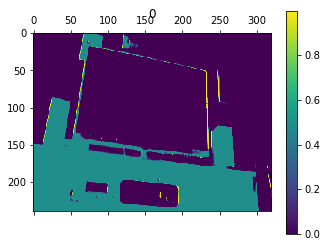

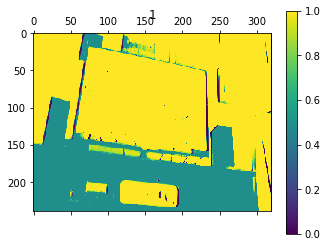

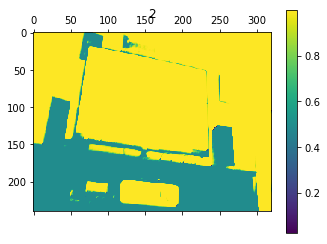

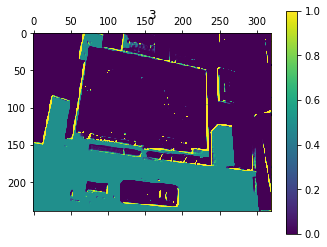

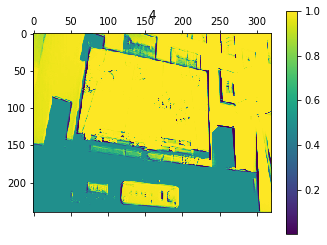

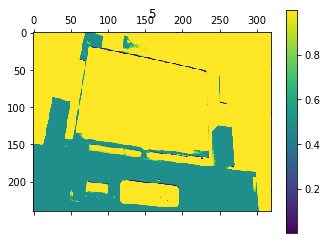

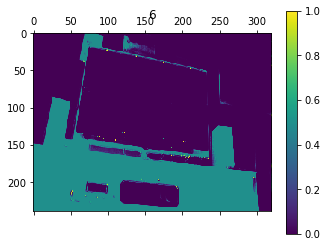

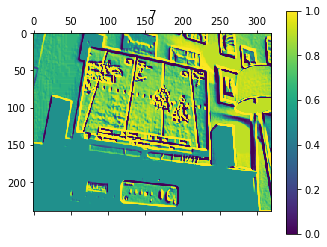

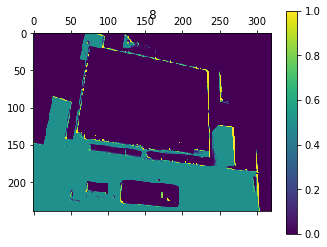

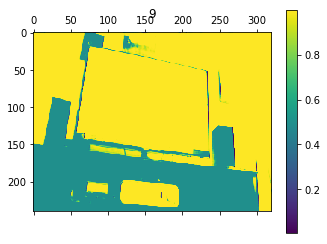

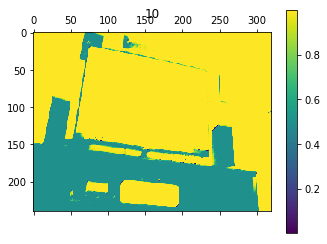

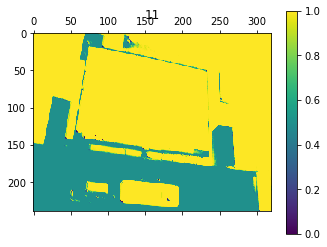

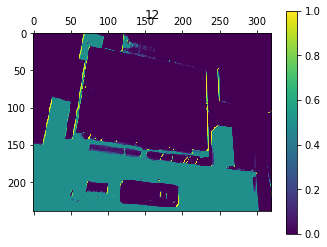

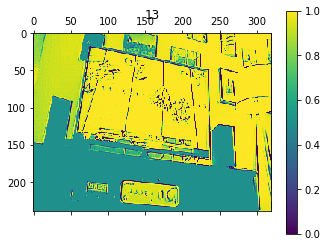

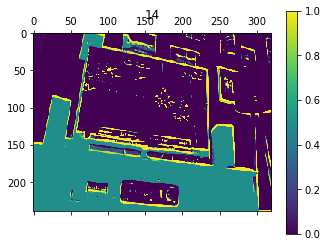

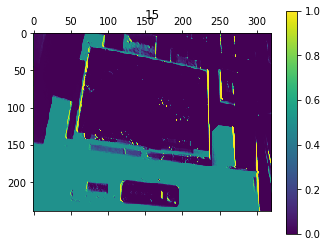

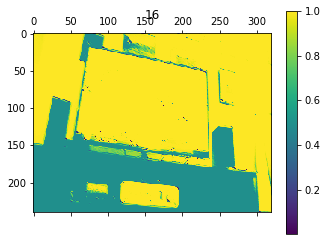

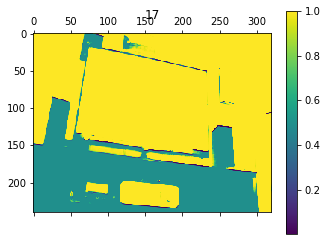

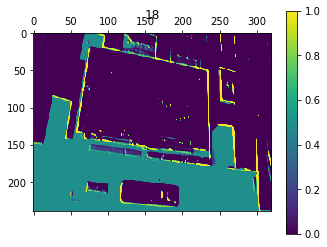

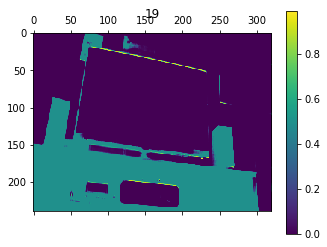

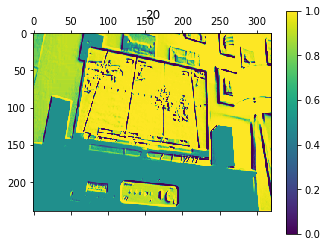

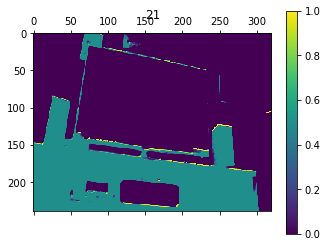

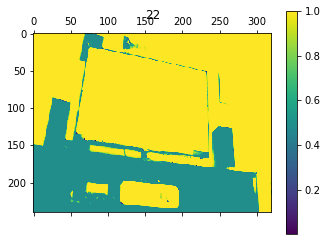

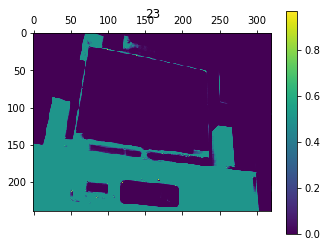

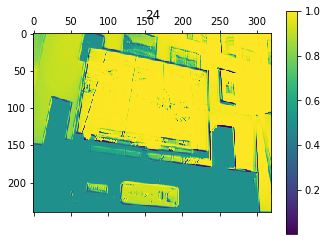

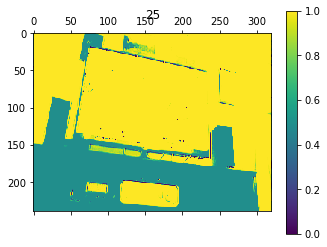

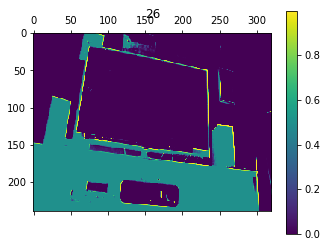

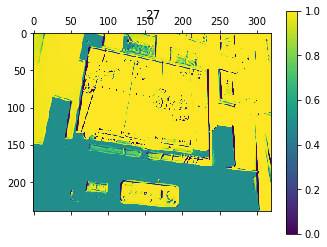

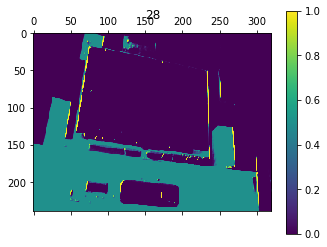

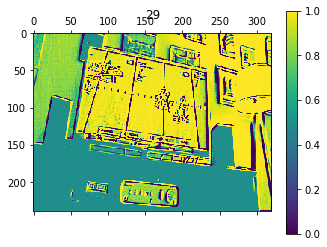

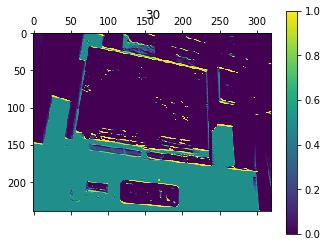

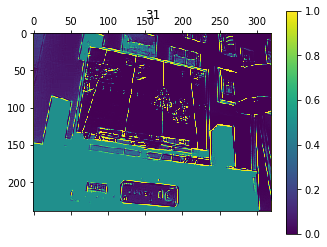

In [125]:
image = test_x[200]
image = image.reshape(data_shape)
H = conv1_1.eval(feed_dict = {X: image})
#H1 = conv2_2.eval(feed_dict= {X: image})

plt.ion()

for i in range(H.shape[3]):
    plt.matshow(H[0, :, :, i])
    plt.title(i)
    plt.colorbar()
plt.show()

In [ ]:
F = biases.eval(sess)

plt.ion()

for i in range(F.shape[3]):
    plt.matshow(F[0, :, :, i])
    plt.title(i)
    plt.colorbar()
plt.show()